## Time Series Challenge
In this challenge, we will compare the various time series prediction techniques on the dataset we can find [here](https://drive.google.com/file/d/1pgZlxluv5_cbgwR5JSWu4njbYXo_06Eb/view?usp=sharing).

- moving average
- ARIMA
- Prophet
- (Stretch) LSTMs

There are several item categories in this sales dataset. You can choose your own category or predict the overall sales.

> #### Note
> We have one order in every row, thus don't forget to transform the data into a time series format first. The data can be transformed into a daily, weekly or monthly time series.

In [46]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

## Moving average

In [47]:
df = pd.read_excel('../data/Sample - Superstore.xls')
df = df[['Order Date', 'Sales']]
df['Order Date'] = pd.to_datetime(df['Order Date'])
df = df.set_index('Order Date')
df = df.resample('M').sum()

<AxesSubplot:xlabel='Order Date'>

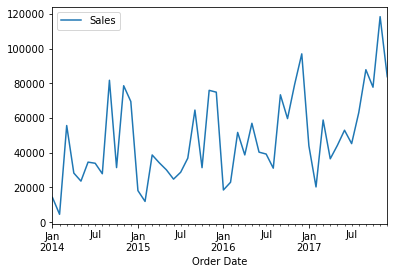

In [36]:
df.plot()

                   Sales
Order Date              
2014-01-31           NaN
2014-02-28           NaN
2014-03-31  24815.932000
2014-04-30  29502.082000
2014-05-31  35878.213667
2014-06-30  28846.253200
2014-07-31  30729.935867
2014-08-31  32150.329700
2014-09-30  47877.737433
2014-10-31  47046.737433


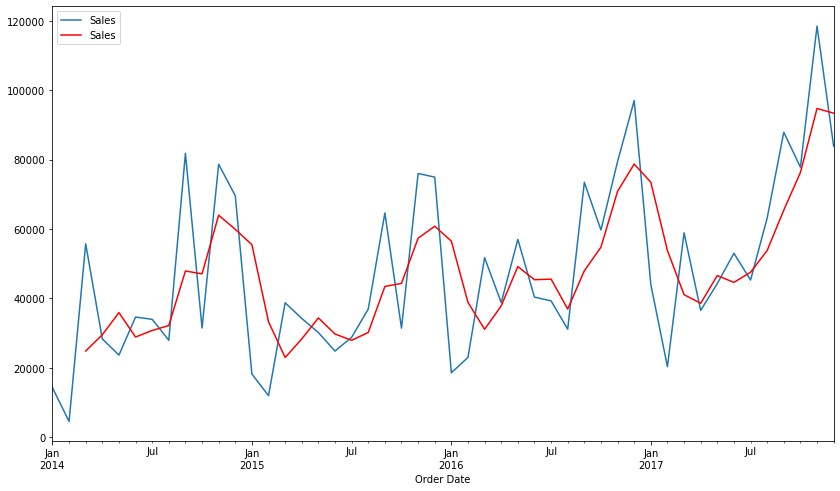

In [39]:
# Tail-rolling average transform
rolling = df.rolling(window=3)
rolling_mean = rolling.mean()
print(rolling_mean.head(10))
# plot original and transformed dataset
fig, ax = plt.subplots(1,figsize=(14,8))
df.plot(ax=ax)
rolling_mean.plot(ax=ax, color='red')
plt.show()

<AxesSubplot:xlabel='Order Date'>

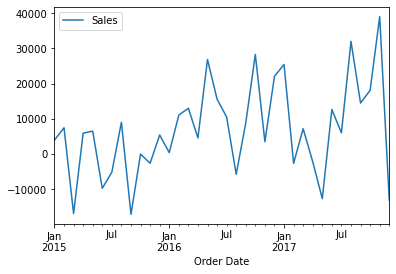

In [38]:
# remove seasonal component by subtracting monthly sales from previous year
df_diff = df.diff(periods=12)[12:]
df_diff.plot()

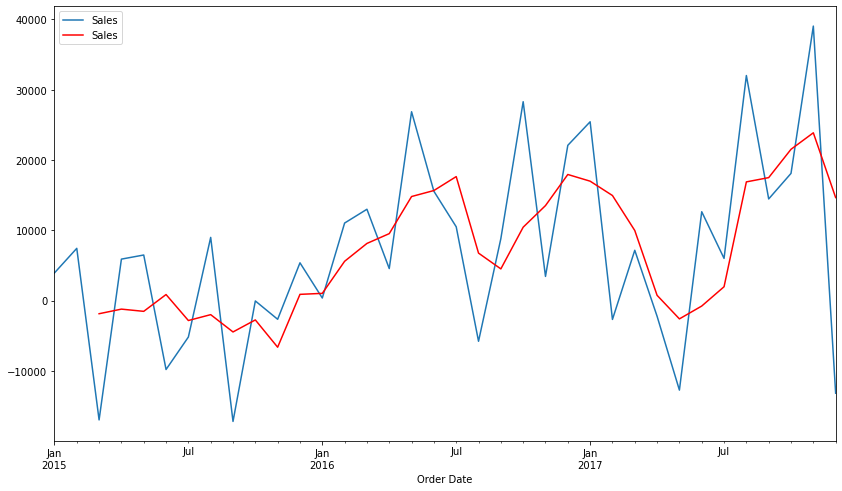

In [31]:
# Tail-rolling average transform
rolling = df_diff.rolling(window=3)
rolling_mean = rolling.mean()
# plot original and transformed dataset
fig, ax = plt.subplots(1,figsize=(14,8))
df_diff.plot(ax=ax)
rolling_mean.plot(ax=ax, color='red')
plt.show()

Test MSE: 547662395.602


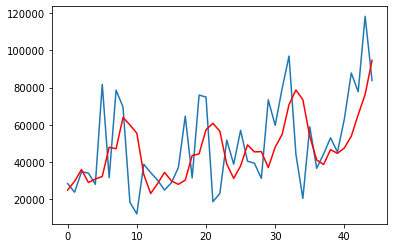

In [44]:
# manual implementation in python
X = df.values
window = 3
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = []
# walk forward over time steps in test
for t in range(len(test)):
    length = len(history)
    yhat = np.mean([history[i] for i in range(length-window,length)])
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    # print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

## FB Prophet

In [1]:
from prophet import Prophet

In [19]:
df_prophet = df.reset_index()
df_prophet.columns = ['ds', 'y']
df_prophet.tail()

,ds,y
43,2017-08-31,63120.8880
44,2017-09-30,87866.6520
45,2017-10-31,77776.9232
46,2017-11-30,118447.8250
47,2017-12-31,83829.3188


In [12]:
m = Prophet()
m.fit(df_prophet)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -59.1729
Iteration  1. Log joint probability =    34.9109. Improved by 94.0838.
Iteration  2. Log joint probability =    67.2169. Improved by 32.306.
Iteration  3. Log joint probability =    83.2875. Improved by 16.0706.
Iteration  4. Log joint probability =    101.479. Improved by 18.1916.
Iteration  5. Log joint probability =    101.484. Improved by 0.00527749.
Iteration  6. Log joint probability =     101.51. Improved by 0.0253589.
Iteration  7. Log joint probability =    101.557. Improved by 0.0471249.
Iteration  8. Log joint probability =    101.629. Improved by 0.0725487.
Iteration  9. Log joint probability =    101.654. Improved by 0.0242715.
Iteration 10. Log joint probability =    101.758. Improved by 0.10412.
Iteration 11. Log joint probability =    103.445. Improved by 1.68696.
Iteration 12. Log joint probability =    103.489. Improved by 0.043785.
Iteration 13. Log joint probability =    103.578. Improved by 0.0898768.
Iteration 14. Log join

In [23]:
future = m.make_future_dataframe(periods=12, freq='M')
forecast = m.predict(future)


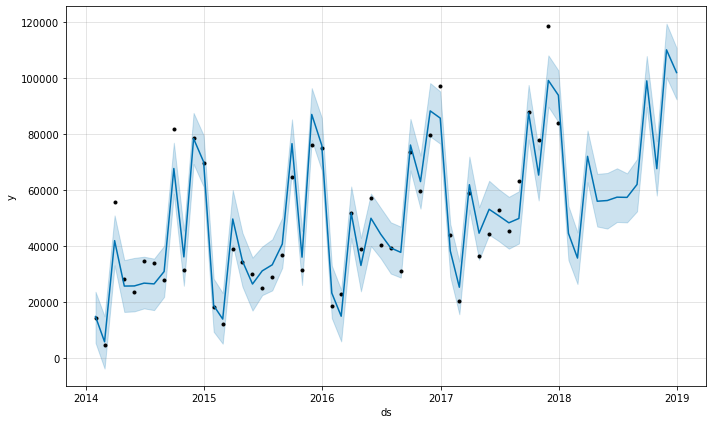

In [24]:
fig1 = m.plot(forecast)

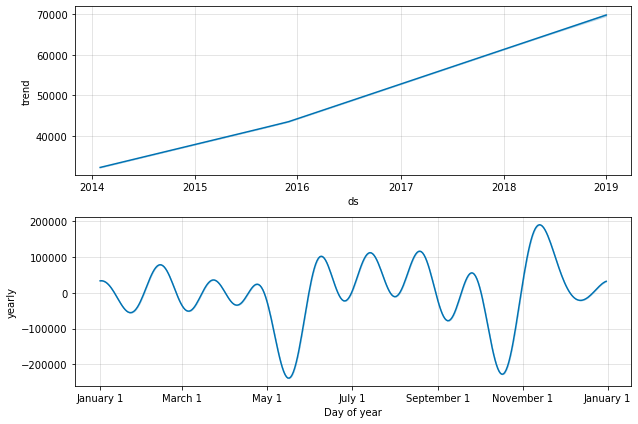

In [25]:
fig2 = m.plot_components(forecast)

## LSTM

In [50]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [59]:
df = pd.read_excel('../data/Sample - Superstore.xls')
df = df[['Order Date', 'Sales']]
df['Order Date'] = pd.to_datetime(df['Order Date'])
df = df.set_index('Order Date')
df = df.resample('W').sum()

In [60]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(df)

In [61]:
X_train = []
y_train = []
for i in range(60, len(df)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [62]:
regressor = Sequential()

#return_sequences: Boolean. Whether to return the last output. in the output sequence, or the full sequence. Default: False.
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.1)) #Dropout takes 10% of neurons and automatically deactivates it. #Used to prevent overfitting 
                            #and to improve generalization of data

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.1))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train, y_train, epochs = 50, batch_size = 52)

2022-01-05 05:55:33.433286: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-05 05:55:33.433398: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-05 05:55:33.433427: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bb0e80c14a3d): /proc/driver/nvidia/version does not exist
2022-01-05 05:55:33.433634: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-05 05:55:34.238811: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the M

Epoch 1/50
3/3 [==============================] - 5s 332ms/step - loss: 0.1079
Epoch 2/50
3/3 [==============================] - 1s 287ms/step - loss: 0.0430
Epoch 3/50
3/3 [==============================] - 1s 319ms/step - loss: 0.0508
Epoch 4/50
3/3 [==============================] - 1s 286ms/step - loss: 0.0401
Epoch 5/50
3/3 [==============================] - 1s 314ms/step - loss: 0.0445
Epoch 6/50
3/3 [==============================] - 1s 316ms/step - loss: 0.0402
Epoch 7/50
3/3 [==============================] - 1s 323ms/step - loss: 0.0378
Epoch 8/50
3/3 [==============================] - 1s 300ms/step - loss: 0.0385
Epoch 9/50
3/3 [==============================] - 1s 284ms/step - loss: 0.0387
Epoch 10/50
3/3 [==============================] - 1s 319ms/step - loss: 0.0364
Epoch 11/50
3/3 [==============================] - 1s 280ms/step - loss: 0.0362
Epoch 12/50
3/3 [==============================] - 1s 268ms/step - loss: 0.0371
Epoch 13/50
3/3 [==============================] 